In [3]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import itertools
import matplotlib.pyplot as plt
import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time
from datetime import datetime
import joblib
from joblib import Parallel, delayed

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import allensdk
import pandas
import h5py
import pynwb
import hdmf
import matplotlib
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

allensdk 2.2.0
pandas 1.3.5
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.1


# Neuropixels data. <a name='data'></a>

In [5]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Download time: 720000


In [6]:
session_id = 798911424  #  791319847 798911424  799864342
session = cache.get_session_data(session_id)

### Neurons Selection

In [28]:
%%time
# Check basic statistics of all probes.
probes = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
display(selected_units['probe_description'].value_counts())
display(selected_units['probe_description'].count())
display(selected_units.groupby(['probe_description', 'ecephys_structure_acronym']).last())

# Then select subset of probes.
probes = ['probeA', 'probeC', 'probeD', 'probeE', 'probeF']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
print('final selected probes', probes)

probeC    94
probeE    89
probeA    78
probeD    78
probeB    57
probeF    47
Name: probe_description, dtype: int64

443

,,L_ratio,presence_ratio,isolation_distance,snr,waveform_duration,nn_miss_rate,waveform_recovery_slope,waveform_velocity_below,firing_rate,cluster_id,local_index_unit,waveform_repolarization_slope,waveform_halfwidth,max_drift,waveform_PT_ratio,cumulative_drift,waveform_spread,amplitude_cutoff,d_prime,waveform_amplitude,peak_channel_id,silhouette_score,nn_hit_rate,waveform_velocity_above,isi_violations,c50_dg,area_rf,fano_dg,fano_fl,fano_ns,fano_rf,fano_sg,f1_f0_dg,g_dsi_dg,g_osi_dg,g_osi_sg,azimuth_rf,mod_idx_dg,p_value_rf,pref_sf_sg,pref_tf_dg,run_mod_dg,run_mod_fl,run_mod_ns,run_mod_rf,run_mod_sg,pref_ori_dg,pref_ori_sg,run_pval_dg,run_pval_fl,run_pval_ns,run_pval_rf,run_pval_sg,elevation_rf,pref_image_ns,pref_phase_sg,firing_rate_dg,firing_rate_fl,firing_rate_ns,firing_rate_rf,firing_rate_sg,on_off_ratio_fl,time_to_peak_ns,pref_sf_multi_sg,pref_tf_multi_dg,pref_ori_multi_dg,pref_ori_multi_sg,pref_phase_multi_sg,image_selectivity_ns,pref_image_multi_ns,lifetime_sparseness_dg,lifetime_sparseness_fl,lifetime_sparseness_ns,lifetime_sparseness_rf,lifetime_sparseness_sg,probe_vertical_position,probe_horizontal_position,probe_id,channel_local_index,ecephys_structure_id,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
probe_description,ecephys_structure_acronym,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
probeA,VISam,0.015568,0.99,56.873778,2.217387,0.714238,0.004750,-0.015566,0.755444,2.330244,392,385,0.182642,0.247236,40.75,0.374745,459.38,50.0,0.022298,4.275154,64.803765,849855994,0.125534,0.963333,2.060302,0.125646,0.060341,700.0,3.257075,0.826667,0.756547,1.308333,0.322535,0.342330,0.025033,0.340267,0.625045,82.857,1.248681,0.000,0.04,1.0,0.027656,0.618182,0.309144,0.611111,0.180976,0.0,0.0,0.876909,0.082969,0.000228,0.216980,7.776317e-04,10.000,4992,0.00,3.965416,0.586179,2.079605,0.878294,5.096403,NaN,0.1165,False,False,False,False,False,0.830508,False,0.488876,0.064000,0.695607,0.460287,0.631725,2700,11,800036196,269,394.0,7613.0,481.0,7559.0,See electrode locations,29999.965974,1249.998582,True
probeB,VISam,0.009419,0.99,535.883528,2.231816,0.233501,0.054688,-0.034283,0.327032,17.989545,287,279,0.239873,0.178559,25.63,0.191810,182.65,90.0,0.009865,4.790931,53.481090,849854722,0.101824,0.997333,0.686767,0.012760,0.124518,300.0,1.427952,1.081905,0.741379,0.708527,1.058712,0.182809,0.045579,0.082039,0.072583,40.000,0.740204,0.000,0.04,2.0,0.140547,0.409060,0.221643,0.305556,0.092159,0.0,150.0,0.007933,0.000027,0.001777,0.035865,3.235461e-01,50.000,4992,0.00,18.205227,18.144899,20.948526,8.370656,24.441554,NaN,0.1225,False,False,False,False,False,0.272542,False,0.021480,0.001556,0.031615,0.167023,0.025828,2560,27,800036198,255,394.0,7943.0,476.0,7422.0,See electrode locations,29999.917201,1249.996550,True
probeC,VISp,0.042912,0.99,37.973009,1.832974,0.755444,0.006829,-0.018379,0.686767,1.047711,420,400,0.131790,0.247236,35.20,0.487796,427.14,60.0,0.021331,2.867965,50.750505,849853312,0.079066,0.575630,1.030151,0.294413,1.065773,900.0,3.230108,1.253333,1.165714,1.911111,0.940000,0.929324,0.091061,0.228532,0.396523,44.444,4.818274,0.000,0.32,2.0,-0.135593,-0.684783,0.570520,-1.000000,0.558036,0.0,0.0,0.693759,0.286903,0.005894,0.009152,2.096170e-04,14.444,4984,0.25,0.822312,0.186511,1.217805,0.678731,1.402826,NaN,0.0915,False,False,False,False,False,0.504254,False,0.373882,0.675676,0.320768,0.586041,0.418974,2360,59,800036200,234,385.0,9130.0,827.0,8239.0,See electrode locations,29999.996048,1249.999835,True
probeD,VISl,0.014502,0.99,56.397459,2.002475,1.263652,0.000921,-0.065126,0.206030,1.574157,393,377,0.010473,0.192295,23.77,13.146540,232.75,60.0,0.010090,5.281608,51.905490,849851976,0.171867,0.962000,0.000000,0.202876,0.565196,300.0,3.110256,0.911667,0.628213,3.533333,1.270639,1.575176,0.294153,0.941154,0.674843,13.333,0.096218,0.007,0.08,1.0,0.676190,0.278997,0.238298,0

final selected probes ['probeA', 'probeC', 'probeD', 'probeE', 'probeF']
Wall time: 81 ms


#### Fine Time Coupling Model

In [8]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
jittertool = jitter.JitterTool()

## Trials Selection

In [9]:
# condition_ids = [251, 255, 261, 270, 278]  # x5  7913
# condition_ids = [251, 255, 261, 270, 278, 284] # x6  7913
# condition_ids = [278, 270, 255, 253, 262, 251, 258, 246, 263, 275, 247, 273]  # x12  7913

# condition_ids = [275, 268, 270, 284, 274, 249, 263, 261, 278, 267, 280, 256, 260, 257, 281]  # x15 7989
# condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]  # x19  7989
# condition_ids = [268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x12 7989
# condition_ids = [270, 274, 249, 265, 261, 286, 258, 278, 280, 260, 257], all 4, 8 Hz

In [32]:
condition_ids = [270, 274, 249, 265, 261, 286, 258, 278, 280, 260, 257]

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
all_condition_ids = list(trials_groups.groups.keys())
model.print_conditions(trials_groups)

0  249 temp freq [8.0] orient [90.0] contrast [0.8] [ 3801  3810  3828  3911  3964 31002 31054 31055 31178 49257 49317 49341 49365 49395 49430]
1  257 temp freq [8.0] orient [315.0] contrast [0.8] [ 3813  3822  3870  3876  3932  3936  3987 31022 31027 31075 31171 49215 49217 49368 49370]
2  258 temp freq [4.0] orient [225.0] contrast [0.8] [ 3814  3895  3922  3967  3986  3997 31043 31151 31152 31175 31196 49251 49282 49340 49414]
3  260 temp freq [4.0] orient [315.0] contrast [0.8] [ 3816  3888  3930  3943  3948 31028 31033 31190 49263 49266 49320 49364 49410 49411 49428]
4  261 temp freq [8.0] orient [135.0] contrast [0.8] [ 3817  3826  3875  3928 31020 31053 31129 31161 31162 49230 49254 49268 49275 49313 49407]
5  265 temp freq [4.0] orient [135.0] contrast [0.8] [ 3824  3848  3880  3920  3953  3955  3960  3968  3973  3992 31039 31093 49232 49339 49383]
6  270 temp freq [8.0] orient [45.0] contrast [0.8] [ 3835  3898  3914  3934 31062 31104 31114 49250 49274 49281 49286 49304 49322 

## Spike Trains

In [11]:
%%time
trial_window = [0.4, 2.0]

# dt=0.002
# spike_train_time_line = np.arange(trial_time_window[0], trial_time_window[1], dt)
# spike_trains = model.get_trial_metric_per_unit_per_trial(
#     stimulus_presentation_ids=all_trials_indices,
#     unit_ids=selected_units.index.values,
#     trial_time_window=trial_time_window,
#     metric_type='spike_trains', dt=dt)
# spike_counts = model.get_trial_metric_per_unit_per_trial(
#         stimulus_presentation_ids=all_trials_indices,
#         unit_ids=selected_units.index.values,
#         trial_time_window=trial_time_window,
#         metric_type='count', empty_fill=0)
spike_times = model.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=all_trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_window,
        metric_type='spike_times')


Wall time: 5min 6s


In [12]:
# display(spike_trains.shape)
# display(spike_trains.iloc[0,0].shape)
display(spike_times.shape)
# display(spike_times.head())

(443, 285)

# Fit individual filter + raw filter clustering.

In [13]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
model.initial_step(None, spike_times, selected_units, trials_groups, trial_window,
                   probes=['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF'], num_areas=6, verbose=False)

conditions: [(0, 246), (1, 249), (2, 256), (3, 257), (4, 258), (5, 260), (6, 261), (7, 263), (8, 265), (9, 267), (10, 268), (11, 270), (12, 274), (13, 275), (14, 278), (15, 280), (16, 281), (17, 284), (18, 286)]


In [14]:
# a = stimulus_table['stimulus_condition_id'].unique(); b = np.setdiff1d(a,select_condition_ids)
# [247, 248, 250, 251, 252, 253, 254, 255, 259, 262, 264, 266, 269, 271, 272, 276, 277, 279, 282, 283, 285]
select_condition_ids = [275, 246, 268, 270, 284, 274,  249, 263, 265, 261, 286, 258,  278, 267, 280, 256, 260, 257, 281]
# select_condition_ids = [275, 246, 268, 270,]

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(select_condition_ids)]
selected_trial_ids = trials_df.index.values
print(selected_trial_ids)

[ 3798  3801  3810  3811  3813  3814  3816  3817  3819  3822  3824  3826  3828  3829  3831  3833  3835  3844
  3845  3848  3852  3855  3859  3860  3862  3866  3870  3872  3875  3876  3878  3880  3881  3882  3884  3886
  3888  3889  3895  3897  3898  3899  3900  3905  3906  3911  3912  3914  3917  3920  3921  3922  3924  3925
  3928  3930  3932  3933  3934  3936  3937  3938  3942  3943  3944  3946  3947  3948  3949  3951  3953  3955
  3956  3958  3959  3960  3962  3964  3966  3967  3968  3973  3979  3980  3981  3984  3986  3987  3988  3989
  3992  3995  3996  3997 31002 31003 31004 31014 31015 31016 31020 31021 31022 31024 31026 31027 31028 31033
 31034 31035 31039 31040 31043 31046 31047 31048 31051 31053 31054 31055 31056 31058 31062 31064 31066 31071
 31072 31075 31076 31078 31079 31080 31081 31085 31086 31089 31093 31096 31098 31104 31105 31112 31114 31116
 31125 31126 31129 31133 31135 31137 31142 31147 31148 31149 31151 31152 31154 31156 31159 31160 31161 31162
 31165 31166 31167 

### Between probes.

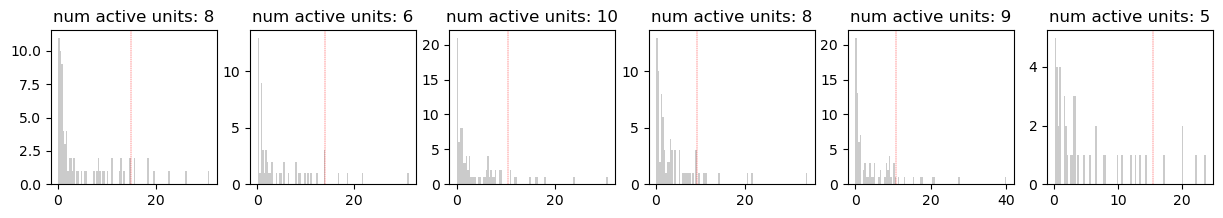

area paris [('probeC', 'probeD')]
num_pairs: 80


In [23]:
active_firing_rate_quantile_threshold = 0.9
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=True)

probe_pair = ('probeC', 'probeD')
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=[probe_pair], verbose=True)
filter_membership = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids, random_val=True)

# probe_pairs = itertools.permutations(['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF'], 2)
# neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
# filter_membership = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids, random_val=True)

#### Select the smoothing kernel width using plug-in estimator (with sub-sampling).

100%|███████████████████████████████████████████████████████████████| 15/15 [00:17<00:00,  1.18s/it]
optimal kernel width  115.0


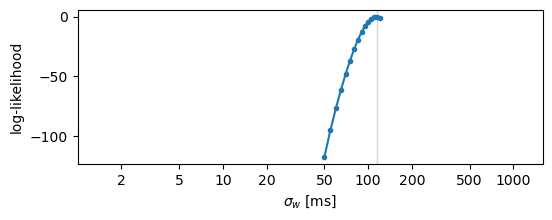

In [16]:
kernel_width_grid = np.arange(50, 125, 5) / 1000
_,_,optimal_kernel_width = model.estimate_nuisance_kernel_width_together(filter_membership, batch_size=2000, kernel_width_grid=kernel_width_grid)

In [24]:
# model_par = {'filter_type': 'bspline', 'num_knots': 8, 'knot_space_par': 0.05, 'filter_length': 0.05, 'num_tail_drop': 1,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 60, 'epsilon': 1e-5}

model_par = {'filter_type': 'square', 'filter_length': 0.04,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.075,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 60, 'epsilon': 1e-5}

model_list = model.pairwise_bivariate_regression(filter_membership, model_par, verbose=False)
# model_list = model.pairwise_bivariate_regression(filter_membership, model_par, verbose=False, parallel=True, num_threads=6)

print('num_models', len(model_list))
timestamp = datetime.now().strftime('%d_%m_%Y_%H%M%S')
model_file = project_dir + f'Output/jitter/coupling_network/model_list_{probe_pair[0]}_to_{probe_pair[1]}_{timestamp}.pkl'
util.save_variable(model_file, model_list)

100%|███████████████████████████████████████████████████████████████| 80/80 [01:40<00:00,  1.26s/it]
num_models 80
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_network/model_list_probeC_to_probeD_29_01_2023_000419.pkl


In [43]:
df_inference = pd.DataFrame(index=filter_membership.index)
df_inference.index.names = ['source', 'target']

for m, (neuron_pair, model_par) in enumerate(model_list):
    pval = jittertool.bivariate_continuous_time_coupling_filter_regression_inference_single(model_par)
    df_inference.loc[neuron_pair, 'pval'] = pval
    num_nuisance = len(model_par['append_nuisance'])
    df_inference.loc[neuron_pair, 'h'] = model_par['beta'][num_nuisance,0]

# display(df_inference)
# display(df_inference[df_inference.pval<1e-4])
df_inference = df_inference.reset_index()
df_inference = pd.merge(df_inference, selected_units[['probe_description']], left_on='source', right_on='unit_id')
df_inference = df_inference.rename(columns={'probe_description': 'source_probe'})
df_inference = pd.merge(df_inference, selected_units[['probe_description']], left_on='target', right_on='unit_id')
df_inference = df_inference.rename(columns={'probe_description': 'target_probe'})

df_inference = pd.merge(df_inference, selected_units[['ecephys_structure_acronym']], left_on='source', right_on='unit_id')
df_inference = df_inference.rename(columns={'ecephys_structure_acronym': 'source_area'})
df_inference = pd.merge(df_inference, selected_units[['ecephys_structure_acronym']], left_on='target', right_on='unit_id')
df_inference = df_inference.rename(columns={'ecephys_structure_acronym': 'target_area'})

df_inference = df_inference.set_index(['source','target'])
df_inference

timestamp = datetime.now().strftime('%d_%m_%Y_%H%M%S')
output_file = project_dir + f'Output/jitter/coupling_network/df_inference_{probe_pair[0]}_to_{probe_pair[1]}_{timestamp}.parquet'
df_inference.to_parquet(output_file)

# Multiple hypothesis test.

In [39]:
# load all df_inference.
import glob
inference_dir = project_dir + 'Output/jitter/coupling_network/'
files = glob.glob(inference_dir + f'session{session_id}_df_inference_*.parquet')

df_inference_all = []
for f in files:
    dfx = pd.read_parquet(f)
    df_inference_all.append(dfx)

df_inference_all = pd.concat(df_inference_all, axis=0)
df_inference_all

,,pval,h,source_probe,target_probe,source_area,target_area
source,target,,,,,,
951092303,951103361,1.598066e-01,0.628878,probeA,probeC,VISam,VISp
951092488,951103361,9.058523e-02,0.662291,probeA,probeC,VISam,VISp
951092973,951103361,1.714054e-01,0.582326,probeA,probeC,VISam,VISp
951092949,951103361,7.315668e-06,2.172775,probeA,probeC,VISam,VISp
951092940,951103361,2.680385e-05,1.413903,probeA,probeC,VISam,VISp
...,...,...,...,...,...,...,...
951092949,951104192,2.233651e-08,3.691088,probeA,probeC,VISam,VISp
951092940,951104192,2.216511e-04,1.667871,probeA,probeC,VISam,VISp
951093080,951104192,4.606810e-02,1.072517,probeA,probeC,VISam,VISp


In [44]:
from statsmodels.stats.multitest import multipletests

test_outcome = multipletests(df_inference.pval.values.reshape(-1), alpha=0.01, method='bonferroni')  # fdr_by, bonferroni
df_inference['significant'] = test_outcome[0]
print('adjusted p-value threshod', test_outcome[2])
df_inference.significant.value_counts()

adjusted p-value threshod 0.00012562130715154662


False    48
True     32
Name: significant, dtype: int64

##### Check individual pair (optinal)

,,3798,3833,3835,3852,3855,3860,3882,3884,3898,3899,3914,3934,3938,3947,3951,3966,3979,3988,31004,31016,31026,31040,31062,31072,31081,31086,31089,31104,31105,31114,31116,31135,31149,31160,31186,31197,31200,49206,49231,49245,49250,49255,49274,49277,49281,49286,49299,49304,49316,49322,49327,49346,49372,49389,49399,49409,49412,49415,49422,49427
source,target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
951108877,951112590,1,4,4,3,3,2,1,3,2,1,0,2,4,3,3,4,0,3,2,0,0,2,1,2,4,3,0,4,3,3,0,4,3,1,0,0,0,2,4,3,4,0,3,4,0,4,3,4,4,0,2,3,0,4,2,3,2,1,1,2


layers 2, nodes 1, trials 60
meanFR 6.758	meanISI 14.047


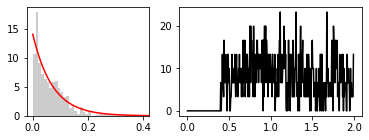

layers 2, nodes 1, trials 60
meanFR 12.475	meanISI 16.972


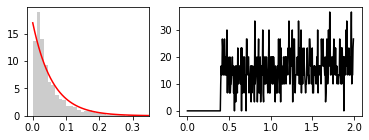

In [101]:
filter_membership_sub = filter_membership_joint.loc[[(951108877, 951112590)]]
display(filter_membership_sub)
spike_times_x, spike_times_y = model.stack_spike_times_by_pairs_all(spike_times, filter_membership_sub, batch_size=None, verbose=False)
jittertool.spike_times_statistics(spike_times_y, trial_window[1], verbose=True)
jittertool.spike_times_statistics(spike_times_x, trial_window[1], verbose=True)


num_trials 60
X.shape (811, 2), basis_integral.shape (2, 1),beta.shape(2, 1)
 53%|███████████████████████████████▊                            | 53/100 [00:00<00:00, 5315.47it/s]
gradient [-0.00013346  0.00072144]
num itr 53 [[-978.22343532]] 8.223355700831547e-06
beta [ 8.44789209 -2.42597097]


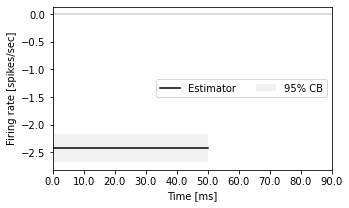

In [109]:
# model_par = {'filter_type': 'bspline', 'num_knots': 2, 'knot_space_par': 0.04, 'filter_length': 0.05, 'num_tail_drop': 1,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.08,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 60, 'epsilon': 1e-5}

# model_par = {'filter_type': 'square', 'filter_length': 0.04,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.08,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 60, 'epsilon': 1e-5}

# model_par = {'filter_type': 'bspline', 'num_knots': 3, 'knot_space_par': 0.04, 'filter_length': 0.05, 'num_tail_drop': 1,
#              'append_nuisance': ['const'], 'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

# model_par = {'filter_type': 'square', 'filter_length': 0.05,
#              'append_nuisance': ['const'], 'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x[:], spike_times_y[:], trial_window, model_par, verbose=True)
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, ylim=None)

### Plot significant edges

{'probeA': ['VISam'], 'probeB': ['VISam'], 'probeC': ['VISp'], 'probeD': ['VISl'], 'probeE': ['VISal'], 'probeF': ['VISrl']}
Save figure to: D:/Brain_Network/Output/fig/between_probe_network.pdf


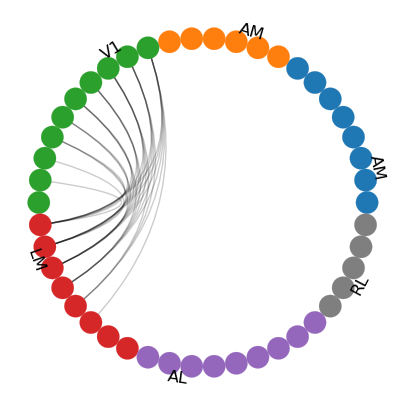

In [46]:
figure_path = project_dir + 'Output/fig/between_probe_network.pdf'
model.build_graph_from_regression_pval(df_inference, layout_units = active_units, figure_path=figure_path)
# model.build_graph_from_regression_pval(df_inference, figure_path=figure_path)

# KS test

In [ ]:
u_list_dict = model.ks_test(spike_times, trial_window, group_model_pars, filter_membership, selected_trial_ids, verbose=False)


In [2007]:
file_path = model_dir + f'CD_ks_test_u_list_dict_x3_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
util.save_variable(file_path, u_list_dict)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021/CD_ks_test_u_list_dict_x3_20211123_213246.pkl


#### Plot all KS plots together.

In [2100]:
model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021/'
# file_path = model_dir + 'CD_ks_test_u_list_dict_x3_20211123_213246.pkl'
file_path = model_dir + 'CD_ks_test_u_list_dict_20211123_144356.pkl'
u_list_dict_0 = util.load_variable(file_path)
file_path = model_dir + 'DE_ks_test_u_list_dict_20211123_192039.pkl'
u_list_dict_1 = util.load_variable(file_path)
u_list_dict = z = {**u_list_dict_0, **u_list_dict_1}

save figure: D:/Brain_Network/Output/fig/CD_DE_condition19_joint_fit_fixed_portion_11122021_KS.pdf


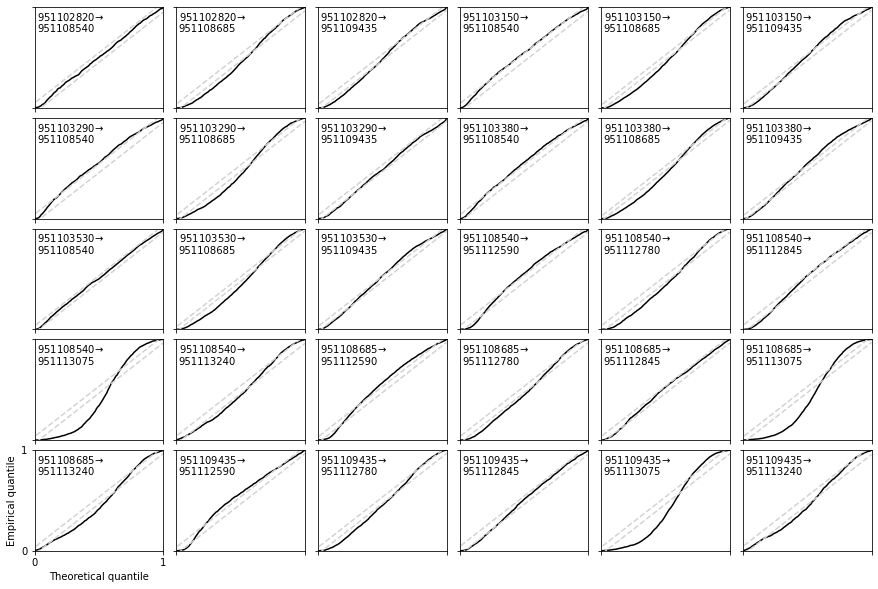

In [2102]:
file_path = project_dir + 'Output/fig/CD_DE_condition19_joint_fit_fixed_portion_11122021_KS.pdf'
model.plot_ks_u_list_dict(u_list_dict, test_size=0.01, file_path=file_path)

In [ ]:
u_list = u_list_dict[(951108685, 951108867)]
u_list = u_list[u_list > 0]
CI_trap, mcdf, ecdf, CI_up, CI_dn = jitter.JitterTool.check_ks(u_list, test_size=0.01, bin_width=0.02, verbose=True)

##### Debugging some errors.  951113075, 951113175 are weird. only one exception.
951109435 951113075

951108685 951113075

951108540 951113075

layers 2, nodes 1, trials 285
meanFR 27.144	meanISI 34.62


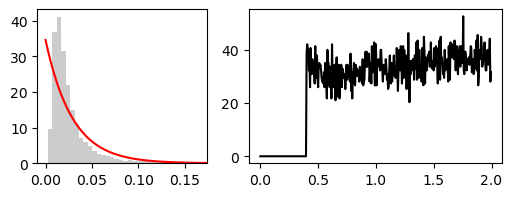

layers 2, nodes 1, trials 285
meanFR 7.358	meanISI 12.33


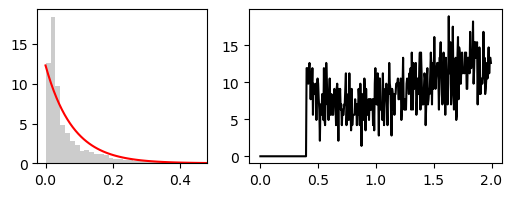

In [22]:
spike_times_x = spike_times.loc[951109319,:].tolist()
spike_times_y = spike_times.loc[951113717,:].tolist()
trial_length = trial_window[1]
jittertool.spike_times_statistics(spike_times_x, trial_length, verbose=True)
jittertool.spike_times_statistics(spike_times_y, trial_length, verbose=True)

num_trials 285
X.shape (4194, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
  9%|█████▍                                                       | 9/100 [00:00<00:00, 1288.66it/s]
gradient [-3.23432971e-05 -5.28686735e-05 -6.55810746e-06]
num itr 9 [[-6215.64457553]] 4.6153603358578543e-07
beta [ 6.89122802  0.75076046 -0.10736803]


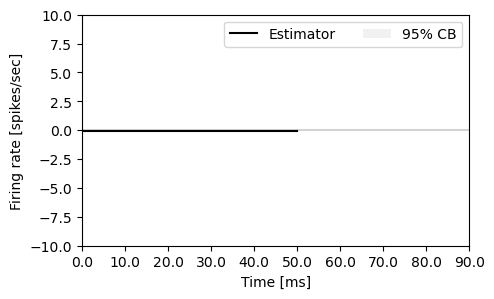

In [23]:
model_par = {'filter_type': 'square', 'filter_length': 0.05,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.075,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}

# model_par = {'filter_type': 'none',
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.08,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-7}

# model_par = {'filter_type': 'none',
#              'append_nuisance': ['const',],
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}

# model_par = {'filter_type': 'bspline', 'num_knots': 5, 'knot_space_par': 0.1, 'filter_length': 0.4, 'num_tail_drop': 1,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.06,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x[:], spike_times_y[:], [0, trial_length], model_par, verbose=True)
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, ylim=[-10,10])

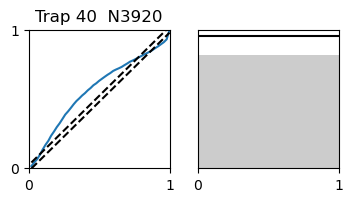

In [24]:
model_par_ks_test = jittertool.ks_test(spike_times_x, spike_times_y, trial_window, model_par_hat, dt=0.001, test_size=0.05, verbose=True)
